<font size = 6> Тестовое задание eLama</font>

# Описание задания

**Используя лог.файлы от внутреннего сервиса прогнозирующего временные ряды ответить на вопросы:**
1. Между какими событиями наибольший шаг? Указать пару идентификаторов событий с наибольшим шагом, относительно всей базы (всех файлов).  
2. Интервал времени до наступления какого события показывает наибольший разброс (разброс - это разность между максимальной и минимальной величинами)? Указать пару идентификатор - sender с наибольшим разбросом. Предложить свои идей, с чем это может быть связано.  
3. Какая задача прогнозирования выполняется дольше всего (название задачи)?  
4. Какое количество задач прогнозирования может выполняться одновременно? Указать максимальное число параллельных задач.  
5. Перечислить forecastMarker которые не завершились успешно.

**Дополнительная информация**  
- Для анализа предоставлены примеры лог.файлов (3 шт.) от внутреннего сервиса прогнозирующего временные ряды. 1 день, 1 файл. Сервис используется в eLama ежедневно, обеспечивает порядка 700 прогнозов различных метрик в сутки. События записываются в базу по мере того, как они случаются.  
- Каждый из файлов представляет собой sqlite базу данных.  
- Первое событие для каждой сессии имеет идентификатор 1. Идентификаторы последующих событий не соответствуют последовательности наступления.  
- Шаг событий - это интервал времени между событиями наступающими друг за другом.  
- Задача прогнозирования считается завершенной успешно, если наступило событие с идентификатором 31.  
- Некоторые задачи прогнозирования могут использовать прогнозы по типу рекурсии. Т.е. при построении прогноза запрашивать прогноз другого параметра, как регрессора. Например при построении прогноза активаций пользователей запрашивается подпрогноз с количеством регистраций. Т.к. регистрации напрямую влияют на количество активаций.

**Описание данных**

`event_name` - таблица с именами событий, которые случаются в сервисе
* id - уникальный идентификатор;
* event_name - название события в рамках сервиса прогнозирования

`events` - сам лог событий
* id - идентификатор конкретного факта наступления события;
* forecastMarker - идентификатор задачи прогнозирования (так мы называем общую задачу прогноза конкретного бизнес-показателя. Есть отдельная таблица, где хранятся свойства задач прогнозирования (источники данных, гиперпараметры, регрессоры и т.д.), (необязательное поле);
* request_time - время когда зафиксировано событие;
* event_id - идентификатор события;
* sender - Имя системы поставившей задачу прогнозирования (необязательное поле);
* context - значения переменных или каких-либо параметров, связанных с событием (необязательно поле);
* session_id - идентификатор исполнения конкретной задачи прогнозирования (используется если задача пришла без forecastMarker и sender)

# Подготовка данных

Предварительно, предоставленные файлы бд sqlite были конвертированы в файлы CSV.  
Для конвертации использовалось ПО: DB Browser for SQLite Version 3.12.2

Для обеспечения работы настоящей тетради на ПК без локальных копий файлов, данные были  выгружены на Google Disk с общим доступом.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
from io import BytesIO
import requests
import datetime
from datetime import date, time
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# создадим словарь, где ключ - имя датасета, а значение - идентификатор таблицы на Google Disk
name_list  = {'event_name_2022-09-12' : '1rxPEGjREPTa1Rz8Wcbpsj5usAGW3dkDqhccw-8u5oZc', 
              'event_name_2022-09-13' : '1UMzGjuXfTzRKbNEwnbVXW82tB61d_n5CGZWvdRsvLXY', 
              'event_name_2022-09-14' : '14ROMUZFCClH7-XbSo_9Dj3TcuNsTCqWqXhEuQPYIjKg'}

events_list= {'events_2022-09-12' : '1HKNUSeRo3zr_ePm-UqZhOE2F_N1Yzbn4fMA5gJkWoGw',
              'events_2022-09-13' : '1E9FCMai0Jq6IJAOrw6ZKUlAV6yZGTJNKxlaHIPHOwA0',
              'events_2022-09-14' : '18IH8oj0ytZSAwxkybDJbYZEgpx3FSVb9okorPgemdhk'}

In [3]:
# Читаем данные и выводим название, info и первые 2 строки
for df_name in name_list:
    try:
        globals()['name' + df_name[-2:]] = pd.read_csv(df_name + ".csv")
    except FileNotFoundError:
        spreadsheet_id = name_list[df_name]
        file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
        r = requests.get(file_name)
        globals()['name' + df_name[-2:]] = pd.read_csv(BytesIO(r.content))
                  
    print(40*'>', 'file name:', df_name)
    print(40*'>', 'dataframe:', 'name' + df_name[-2:])
    globals()['name' + df_name[-2:]].info()
    display(globals()['name' + df_name[-2:]].head(2))
    print()
    
for df_name in events_list:
    try:
        globals()['ivents' + df_name[-2:]] = pd.read_csv(df_name + ".csv")
    except FileNotFoundError:
        spreadsheet_id = events_list[df_name]
        file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
        r = requests.get(file_name)
        globals()['ivents' + df_name[-2:]] = pd.read_csv(BytesIO(r.content))
                  
    print(40*'>', 'file name:', df_name)
    print(40*'>', 'dataframe:', 'ivents' + df_name[-2:])
    globals()['ivents' + df_name[-2:]].info()
    display(globals()['ivents' + df_name[-2:]].head(2))
    print()    

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: event_name_2022-09-12
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: name12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34 non-null     int64 
 1   event_name  34 non-null     object
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes


,id,event_name
0,1,Инициализируем свойства класса
1,2,Переход в функцию getParametrsAndRegressors



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: event_name_2022-09-13
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: name13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34 non-null     int64 
 1   event_name  34 non-null     object
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes


,id,event_name
0,1,Инициализируем свойства класса
1,2,Переход в функцию getParametrsAndRegressors



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: event_name_2022-09-14
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: name14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34 non-null     int64 
 1   event_name  34 non-null     object
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes


,id,event_name
0,1,Инициализируем свойства класса
1,2,Переход в функцию getParametrsAndRegressors



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: events_2022-09-12
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: ivents12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11207 entries, 0 to 11206
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11207 non-null  int64 
 1   forecastMarker  11207 non-null  object
 2   request_time    11207 non-null  object
 3   event_id        11207 non-null  int64 
 4   sender          11207 non-null  object
 5   context         11207 non-null  object
 6   session_id      11207 non-null  object
dtypes: int64(2), object(5)
memory usage: 613.0+ KB


,id,forecastMarker,request_time,event_id,sender,context,session_id
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'N...",6f4277f6df57c4f4e90779966522c876
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: events_2022-09-13
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: ivents13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22275 entries, 0 to 22274
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              22275 non-null  int64 
 1   forecastMarker  22275 non-null  object
 2   request_time    22275 non-null  object
 3   event_id        22275 non-null  int64 
 4   sender          22275 non-null  object
 5   context         22275 non-null  object
 6   session_id      22275 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.2+ MB


,id,forecastMarker,request_time,event_id,sender,context,session_id
0,1,None,2022-09-13 00:10:27.967745,1,None,"df = <class 'pandas.core.frame.DataFrame'>, sq...",fa89a4d46b9b34761a580f0152f94f05
1,2,None,2022-09-13 00:10:27.972425,29,None,None,fa89a4d46b9b34761a580f0152f94f05



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> file name: events_2022-09-14
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> dataframe: ivents14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11249 entries, 0 to 11248
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11249 non-null  int64 
 1   forecastMarker  11249 non-null  object
 2   request_time    11249 non-null  object
 3   event_id        11249 non-null  int64 
 4   sender          11249 non-null  object
 5   context         11249 non-null  object
 6   session_id      11249 non-null  object
dtypes: int64(2), object(5)
memory usage: 615.3+ KB


,id,forecastMarker,request_time,event_id,sender,context,session_id
0,1,None,2022-09-14 00:09:39.234361,1,None,"df = <class 'pandas.core.frame.DataFrame'>, sq...",ec6a82e4a1b9b4dc467639eb1a5d6987
1,2,None,2022-09-14 00:09:39.238851,29,None,None,ec6a82e4a1b9b4dc467639eb1a5d6987


Датасеты event_name за разные даты похожи. Проведём их сверку. Для этого объединим три датасета по индексам и проверим идентичность записей в каждой строке.

In [4]:
tm = pd.merge(name12, name13, how='outer', on='id')
tm = pd.merge(tm, name14, how='outer', on='id')

In [5]:
pd.set_option('display.max_colwidth', 0)

In [6]:
tm.info()
tm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            34 non-null     int64 
 1   event_name_x  34 non-null     object
 2   event_name_y  34 non-null     object
 3   event_name    34 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.3+ KB


,id,event_name_x,event_name_y,event_name
0,1,Инициализируем свойства класса,Инициализируем свойства класса,Инициализируем свойства класса
1,2,Переход в функцию getParametrsAndRegressors,Переход в функцию getParametrsAndRegressors,Переход в функцию getParametrsAndRegressors
2,3,Выход из функции getParametrsAndRegressors с параметрами,Выход из функции getParametrsAndRegressors с параметрами,Выход из функции getParametrsAndRegressors с параметрами
3,4,Выход из функции getParametrsAndRegressors БЕЗ параметров,Выход из функции getParametrsAndRegressors БЕЗ параметров,Выход из функции getParametrsAndRegressors БЕЗ параметров
4,5,Записали в свойства класса гиперпараметры и регрессоры,Записали в свойства класса гиперпараметры и регрессоры,Записали в свойства класса гиперпараметры и регрессоры


В новой таблице нет пропусков, значит для каждого дня наюор id событий идентичен. Проверим идентичность описаний.

In [7]:
# функция для сравнения описаний
# если содержимое трёх ячеек в одной строке идентично, то в строку добавляем ячейку со значением 1
# если есть различия, то то в строку добавляем ячейку со значением 0
def comparison(row):
    if row['event_name_x'] == row['event_name_y'] and row['event_name_x'] == row['event_name']: row['check'] = 1
    else: row['check'] = 0
    return row

In [8]:
# применяем функцию к датасету и смотрим на уникальные записи столбца `check`
tm = tm.apply(comparison, axis=1)
tm['check'].unique()

array([1], dtype=int64)

столбец содержит только 1, следовательно, name12, name13, name14 идентичны. Можем использовать любой из них.

In [9]:
names = name12

Датассеты events так же не содержат пропусков. Если событий 12-го  и 14-го  примерно одинаковое количество, то 13-го событий вдвое больше. Для столбца `request_time` требуется изменение формата данных. Оценим число задач прогнозирования для каждого из дней. Согласно описания, каждая задача имеет уникальный `session_id`.

In [10]:
print(f'Число задач 12-09-2022: {ivents12["session_id"].nunique()}, число событий: {ivents12.shape[0]}')
print(f'Число задач 13-09-2022: {ivents13["session_id"].nunique()}, число событий: {ivents13.shape[0]}')
print(f'Число задач 14-09-2022: {ivents14["session_id"].nunique()}, число событий: {ivents14.shape[0]}')

Число задач 12-09-2022: 371, число событий: 11207
Число задач 13-09-2022: 789, число событий: 22275
Число задач 14-09-2022: 439, число событий: 11249


Число задач, так же как и число событий 13-го числа оказалось вдвое больше, чем 12-го. 

Датасеты относительно небольшие. Поэтому, объединим их в один.

In [11]:
ivents = pd.merge(ivents12, ivents13, how='outer')

In [12]:
ivents = pd.merge(ivents, ivents14, how='outer')

In [13]:
ivents.head()

,id,forecastMarker,request_time,event_id,sender,context,session_id
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",6f4277f6df57c4f4e90779966522c876
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876
2,3,SelfService/RUS/turnover,2022-09-12 11:30:11.115989,2,test_system,None,6f4277f6df57c4f4e90779966522c876
3,4,SelfService/RUS/turnover,2022-09-12 11:30:12.761754,3,test_system,Найдено 1 строк с параметрами,6f4277f6df57c4f4e90779966522c876
4,5,SelfService/RUS/turnover,2022-09-12 11:30:12.770134,5,test_system,None,6f4277f6df57c4f4e90779966522c876


In [14]:
ivents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44731 entries, 0 to 44730
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              44731 non-null  int64 
 1   forecastMarker  44731 non-null  object
 2   request_time    44731 non-null  object
 3   event_id        44731 non-null  int64 
 4   sender          44731 non-null  object
 5   context         44731 non-null  object
 6   session_id      44731 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.7+ MB


In [15]:
ivents.duplicated().sum()

0

Дубликаты отсутствуют.

Преобразуем формат данных и выделим дату в отдельный столбец.

In [16]:
ivents['request_time'] = pd.to_datetime(ivents['request_time'], format='%Y-%m-%d %H:%M:%S')
ivents['date'] = pd.DatetimeIndex(ivents['request_time']).date
ivents.info()
ivents.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44731 entries, 0 to 44730
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              44731 non-null  int64         
 1   forecastMarker  44731 non-null  object        
 2   request_time    44731 non-null  datetime64[ns]
 3   event_id        44731 non-null  int64         
 4   sender          44731 non-null  object        
 5   context         44731 non-null  object        
 6   session_id      44731 non-null  object        
 7   date            44731 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.1+ MB


,id,forecastMarker,request_time,event_id,sender,context,session_id,date
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",6f4277f6df57c4f4e90779966522c876,2022-09-12
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876,2022-09-12


Добавим наименование событий.

In [17]:
ivents = pd.merge(ivents, names, how='left', left_on='event_id', right_on='id')
ivents = ivents.drop(columns='id_y')

In [18]:
ivents.head(2)

,id_x,forecastMarker,request_time,event_id,sender,context,session_id,date,event_name
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",6f4277f6df57c4f4e90779966522c876,2022-09-12,Инициализируем свойства класса
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876,2022-09-12,Начинаем получать гипермараметры и регрессоры


Сравним распределения событий в течении дня.

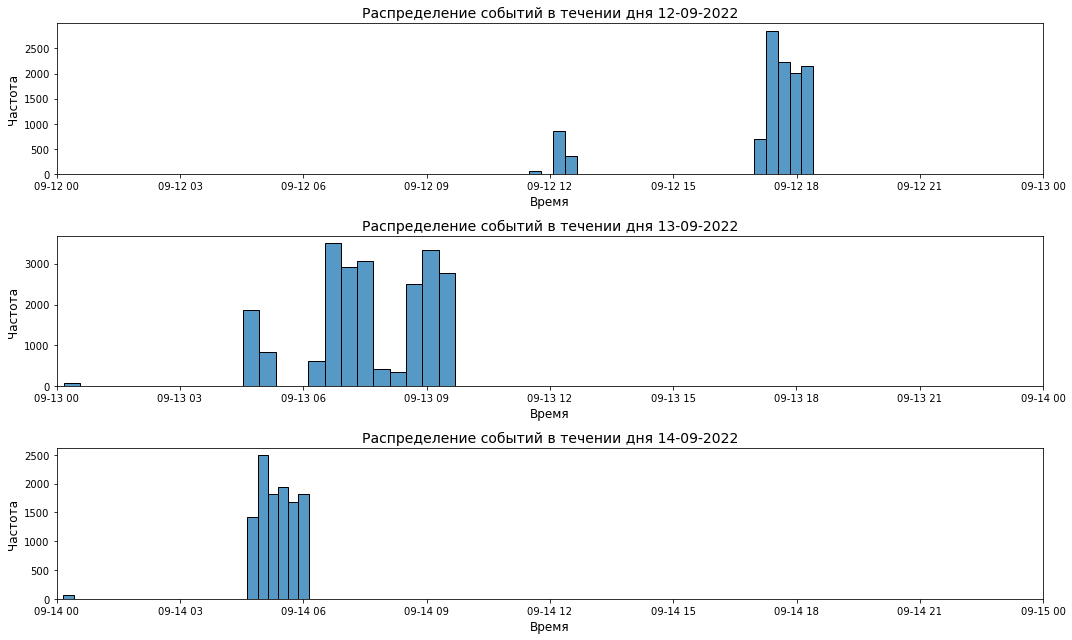

In [19]:
fig2 = plt.figure(figsize=(15,9))
ax1 = fig2.add_subplot(3,1,1)
ax2 = fig2.add_subplot(3,1,2)
ax3 = fig2.add_subplot(3,1,3)

sns.histplot(x='request_time', data=ivents.query('date == datetime.date(2022, 9, 12)'), bins=24, ax = ax1)
ax1.set_title('Распределение событий в течении дня 12-09-2022', fontsize=14)
ax1.set_xlabel('Время', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.set_xlim(datetime.datetime(2022, 9, 12, 0, 0, 0), datetime.datetime(2022, 9, 13, 0, 0, 0))

sns.histplot(x='request_time', data=ivents.query('date == datetime.date(2022, 9, 13)'), bins=24, ax = ax2)
ax2.set_title('Распределение событий в течении дня 13-09-2022', fontsize=14)
ax2.set_xlabel('Время', fontsize=12)
ax2.set_ylabel('Частота', fontsize=12)
ax2.set_xlim(datetime.datetime(2022, 9, 13, 0, 0, 0), datetime.datetime(2022, 9, 14, 0, 0, 0))

sns.histplot(x='request_time', data=ivents.query('date == datetime.date(2022, 9, 14)'), bins=24, ax = ax3)
ax3.set_title('Распределение событий в течении дня 14-09-2022', fontsize=14)
ax3.set_xlabel('Время', fontsize=12)
ax3.set_ylabel('Частота', fontsize=12)
ax3.set_xlim(datetime.datetime(2022, 9, 14, 0, 0, 0), datetime.datetime(2022, 9, 15, 0, 0, 0))

fig2.tight_layout()

Гистограммы, для удобства сравнения, построены на одинаковых осях времени (0:00:00 текущего дня до 0:00:00 следующего дня). Для 13-го и 14-го числа первая активность фиксируется в начале суток, тогда как 12-го числа только ближе в полудню. Возможно, это связано с тем, что 12-09-2022 это был понедельник, а для первого рабочего дня характерна низкая активность в первой половине. Тем не менее, для всех трёх дней характерна непостоянная загруженность в течении дня с пиком в первой половине по времени системы. 

Выведем время первой, последей активности и интервал между ними по дням.

In [20]:
for day in [12, 13, 14]:
    print(f'{day}-09-2022')
    print('Первая активность   :',ivents.query('date == datetime.date(2022, 9, @day)')['request_time'].min())
    print('Последняя активность:',ivents.query('date == datetime.date(2022, 9, @day)')['request_time'].max())
    print('Интервал            : ', end='')
    print(
        ivents.query('date == datetime.date(2022, 9, @day)')['request_time'].max() - 
        ivents.query('date == datetime.date(2022, 9, @day)')['request_time'].min())

12-09-2022
Первая активность   : 2022-09-12 11:30:11.106628
Последняя активность: 2022-09-12 18:24:18.389464
Интервал            : 0 days 06:54:07.282836
13-09-2022
Первая активность   : 2022-09-13 00:10:27.967745
Последняя активность: 2022-09-13 09:41:15.078643
Интервал            : 0 days 09:30:47.110898
14-09-2022
Первая активность   : 2022-09-14 00:09:39.234361
Последняя активность: 2022-09-14 06:07:47.609898
Интервал            : 0 days 05:58:08.375537


Интервалы между первой и последней активности от 6 до 9.5 часов. 14-го числа все активности прекращены уже к 6 утра.

# Ответы на вопросы

## Между какими событиями наибольший шаг? Указать пару идентификаторов событий с наибольшим шагом, относительно всей базы.

In [21]:
# исключение предупреждения python
pd.options.mode.chained_assignment = None

Так как в задании однозначно не указано, должны ли быть события внутри одной задачи или нет, рассмотрим оба варианта:
- наибольший шаг между событиями (все события в хронологическом порядке);
- наибольший шаг между событиями (события в рамках одной задачи)

### Наибольший шаг между событиями (все события в хронологическом порядке).

In [22]:
tmp = ivents
tmp['prev_time'] = tmp['request_time'].shift(1)
tmp['time_delta'] = tmp['request_time'] - tmp['prev_time']
print("Наибольший шаг:",tmp['time_delta'].max())

Наибольший шаг: 0 days 14:28:24.155718


Выведем эти события.

In [23]:
(
    tmp.loc[tmp.loc[tmp['time_delta'] == tmp['time_delta'].max()].index[0]-1 :
            tmp.loc[tmp['time_delta'] == tmp['time_delta'].max()].index[0], 
            ['forecastMarker', 'request_time', 'event_id', 'sender', 'context', 'session_id']]
)    

,forecastMarker,request_time,event_id,sender,context,session_id
33481,weekly_report.SS:no_segment_users,2022-09-13 09:41:15.078643,31,test.weekly_report.ss,"Отдан датафрейм: (895, 4)",d637d1b6d2b70fd088e2ea44959483cb
33482,None,2022-09-14 00:09:39.234361,1,None,"df = <class 'pandas.core.frame.DataFrame'>, sql_query = <class 'NoneType'>",ec6a82e4a1b9b4dc467639eb1a5d6987


Как и следовало ожидать, исходя из графиков активностей представленных выше, наибольший шаг (бездействие системы) между завершением последней задачи 13-го и началом первой задачи 14-го сентября.

### Наибольший шаг между событиями (события в рамках одной задачи).

Создадим датасет в котором для каждого события найдём время предыдущего события той же задачи и шаг между ними.

In [24]:
dft31 = pd.DataFrame(columns=['id_x', 'forecastMarker', 'request_time', 'event_id', 
                             'sender', 'context', 'session_id', 'event_name', 'prev_time', 
                             'prev_id', 'time_delta'])

In [25]:
for i in tqdm(ivents['session_id'].unique()):
    tmp = ivents.query('session_id == @i')
    tmp['prev_time']  = tmp['request_time'].shift(1)
    tmp['prev_id'] = tmp['event_id'].shift(1)
    tmp['time_delta'] = tmp['request_time'] - tmp['prev_time']
    dft31 = pd.merge(dft31, tmp, how='outer')
dft31.head(2)    

100%|██████████████████████████████████████| 1599/1599 [02:46<00:00,  9.60it/s]


,id_x,forecastMarker,request_time,event_id,sender,context,session_id,date,event_name,prev_time,time_delta,prev_id
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",6f4277f6df57c4f4e90779966522c876,2022-09-12,Инициализируем свойства класса,NaT,NaT,NaN
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876,2022-09-12,Начинаем получать гипермараметры и регрессоры,2022-09-12 11:30:11.106628,0 days 00:00:00.004731,1.0


Выведем строку с максимальным шагом.

In [26]:
dft31.loc[dft31['time_delta'] == dft31['time_delta'].max()]

,id_x,forecastMarker,request_time,event_id,sender,context,session_id,date,event_name,prev_time,time_delta,prev_id
39225,5744,weekly_report.care:count_of_jivo_SA,2022-09-14 05:22:40.308128,7,weekly_report.care,"Получили из BQ набор данных размером: (548, 2)",4dcab2af4573ced8251fb7433174ba15,2022-09-14,Получили данные из BQ по полученному SQL запросу,2022-09-14 05:20:53.759918,0 days 00:01:46.548210,6.0


In [27]:
tmp = dft31.loc[dft31['time_delta'] == dft31['time_delta'].max()].reset_index()
step = round(tmp['time_delta'].max().total_seconds(), 2)
curr_id = int(tmp['event_id'])
prev_id = int(tmp['prev_id'])
print(f"Максимальный шаг: {step} сек.")
print(f"Дата и время предыдущего события : {tmp.loc[0, 'prev_time']}")
print(f"Предыдущее событие идентификатор : {prev_id}")
print(f"Предыдущее событие наименование  : {names.loc[names.loc[names['id'] == prev_id].index[0], 'event_name']}")
print(f"Дата и время текущего события    : {tmp.loc[0, 'request_time']}")
print(f"Текущее событие идентификатор    : {curr_id}")
print(f"Текущее событие наименование     : {tmp.loc[0, 'event_name']}")

Максимальный шаг: 106.55 сек.
Дата и время предыдущего события : 2022-09-14 05:20:53.759918
Предыдущее событие идентификатор : 6
Предыдущее событие наименование  : Начинаем читать данные из BQ по полученному SQL запросу
Дата и время текущего события    : 2022-09-14 05:22:40.308128
Текущее событие идентификатор    : 7
Текущее событие наименование     : Получили данные из BQ по полученному SQL запросу


## Интервал времени до наступления какого события показывает наибольший разброс? Указать пару идентификатор - sender с наибольшим разбросом. 

По условию задачи, разброс - это разность между максимальной и минимальной величинами. Так как требуются указать пару идентификатор - sender, необходимо анализировать интервалы по всем возможным парам.

Добавим столбец с шагом в секундах.

In [28]:
dft31['delta_in_sec'] = dft31['time_delta'].apply(lambda x: x.total_seconds())
dft31.head(2)

,id_x,forecastMarker,request_time,event_id,sender,context,session_id,date,event_name,prev_time,time_delta,prev_id,delta_in_sec
0,1,SelfService/RUS/turnover,2022-09-12 11:30:11.106628,1,test_system,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",6f4277f6df57c4f4e90779966522c876,2022-09-12,Инициализируем свойства класса,NaT,NaT,NaN,NaN
1,2,SelfService/RUS/turnover,2022-09-12 11:30:11.111359,29,test_system,None,6f4277f6df57c4f4e90779966522c876,2022-09-12,Начинаем получать гипермараметры и регрессоры,2022-09-12 11:30:11.106628,0 days 00:00:00.004731,1.0,0.004731


Для каждой пары идентификатор - sender рпределим минимальную, максимальную продолжительность интервалов до наступления события, а так же расчитаем разброс.

In [29]:
id_sender_range = dft31.groupby(['event_id', 'sender']).agg({'delta_in_sec': ['min', 'max']}).reset_index()
id_sender_range.columns=['event_id', 'sender', 'delta_min', 'delta_max']
id_sender_range['range'] = id_sender_range['delta_max'] - id_sender_range['delta_min']
id_sender_range.sample(5)

,event_id,sender,delta_min,delta_max,range
16,1,"internal_call for SelfService/RUS/turnover, session_id: 6f4277f6df57c4f4e90779966522c876",NaN,NaN,NaN
81,3,test.weekly_report.sa,1.367941,2.327560,0.959619
31,1,weekly_report.sa,NaN,NaN,NaN
525,17,test.weekly_report.care,0.003981,0.078917,0.074936
329,12,forecast_for_PHR.load_prophet_forecast_data,0.004703,0.189871,0.185168


Выведем пару идентификатор - sender с наибольшим разбросом.

In [30]:
id_sender_range.loc[id_sender_range['range'] == id_sender_range['range'].max()][['event_id', 'sender']]

,event_id,sender
181,7,weekly_report.care


Выведем на нименование события.

In [31]:
names.loc[names['id'] == (
    id_sender_range.loc[id_sender_range['range'] == id_sender_range['range'].max()].iloc[0]['event_id'])]

,id,event_name
6,7,Получили данные из BQ по полученному SQL запросу


Большой разброс для события с id 7, вероятно, связан с объемами данных по запросу. Посмотрим единичный ли это выброс, или для id 7 это в целом характерно.

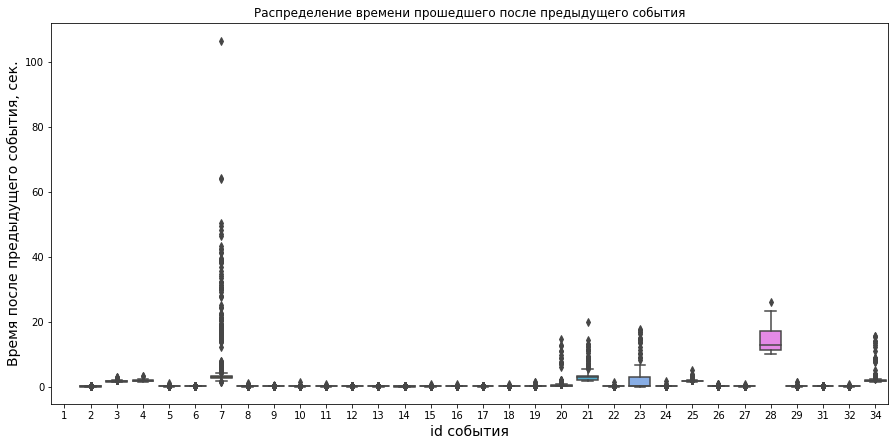

In [32]:
plt.figure(figsize=(15,7))
sns.boxplot(x='event_id', y='delta_in_sec', data=dft31)
plt.title('Распределение времени прошедшего после предыдущего события')
plt.xlabel("id события", fontsize=14)
plt.ylabel("Время после предыдущего события, сек.", fontsize=14)
plt.show()

Именно для id 7 характерны самые большие интервалы времени прошедшего с предыдущего события.

## Какая задача прогнозирования выполняется дольше всего (название задачи)?

Для ответа на вопрос создадим датасев который будет содержать:
- session_id уникальный идентификатор задачи
- session_start время первого события (id 1) в рамках задачи
- session_end время последнего события (id 31) в рамках задачи

Для незавершенных задач:
- принимаем session_end равным времени последнего зафиксированного события задачи
- сохраняем session_id в список незавершенных задач no_end_sessions

In [33]:
session_name = []
session_st = []
session_fn = []
no_end_sessions = []
for session in tqdm(ivents['session_id'].unique()):
    session_name.append(session)
    session_st.append(ivents.query('session_id == @session & event_id == 1').reset_index()['request_time'][0])
    try: 
        session_fn.append(ivents.query('session_id == @session & event_id == 31').reset_index()['request_time'][0])
    except: 
        no_end_sessions.append(session)
        idx = ivents.query('session_id == @session').reset_index().shape[0] - 1
        session_fn.append(ivents.query('session_id == @session').reset_index().loc[idx, 'request_time'])
dft33 = pd.DataFrame(
    {'session_id' : session_name,
    'session_start' : session_st,
    'session_end' : session_fn})
dft33.head()

100%|██████████████████████████████████████| 1599/1599 [00:31<00:00, 51.00it/s]


,session_id,session_start,session_end
0,6f4277f6df57c4f4e90779966522c876,2022-09-12 11:30:11.106628,2022-09-12 11:30:36.249818
1,ba9c7ee046c9fbdc0c8713c86409bdc3,2022-09-12 11:30:18.666983,2022-09-12 11:30:29.936695
2,f425376c334840a59b585165f9ca87dc,2022-09-12 12:13:46.808490,2022-09-12 12:13:57.512095
3,58e407a7bc512bc4b282457c05893ebc,2022-09-12 12:14:04.816840,2022-09-12 12:14:15.082298
4,7c25b8a1058e6c036c443b8cd6dd8c69,2022-09-12 12:14:19.332540,2022-09-12 12:14:31.408749


In [34]:
# незавершенные задачи
no_end_sessions

['56af71228bfbb91afd00a04652646069',
 'ef2ce869aedbddee01530295d44a5993',
 '05fde45de80ea82b620d924acf35410c',
 '9dd140e965fe9c98656a0d0e405aa1e8',
 '56e957cb0972c856c211dfed092dc8c2']

In [35]:
# добавим время выполнения задачи
dft33['session_duration'] = dft33['session_end'] - dft33['session_start']
dft33.head(2)

,session_id,session_start,session_end,session_duration
0,6f4277f6df57c4f4e90779966522c876,2022-09-12 11:30:11.106628,2022-09-12 11:30:36.249818,0 days 00:00:25.143190
1,ba9c7ee046c9fbdc0c8713c86409bdc3,2022-09-12 11:30:18.666983,2022-09-12 11:30:29.936695,0 days 00:00:11.269712


In [36]:
max_duration = dft33['session_duration'].max()
print(f'Наибольшая продолжительность выполнения: {max_duration.total_seconds()} сек.')
session_with_max_duration = dft33.loc[dft33['session_duration'] == max_duration].reset_index()['session_id'][0]

Наибольшая продолжительность выполнения: 112.484473 сек.


Посмотрим на задачу с максимальной продолжительностью

In [37]:
ivents.query('session_id==@session_with_max_duration')

,id_x,forecastMarker,request_time,event_id,sender,context,session_id,date,event_name,prev_time,time_delta
39219,5738,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:52.203702,1,weekly_report.care,"df = <class 'NoneType'>, sql_query = <class 'NoneType'>",4dcab2af4573ced8251fb7433174ba15,2022-09-14,Инициализируем свойства класса,2022-09-14 05:20:51.663820,0 days 00:00:00.539882
39220,5739,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:52.210420,29,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,Начинаем получать гипермараметры и регрессоры,2022-09-14 05:20:52.203702,0 days 00:00:00.006718
39221,5740,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:52.214649,2,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,Переход в функцию getParametrsAndRegressors,2022-09-14 05:20:52.210420,0 days 00:00:00.004229
39222,5741,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:53.747368,3,weekly_report.care,Найдено 1 строк с параметрами,4dcab2af4573ced8251fb7433174ba15,2022-09-14,Выход из функции getParametrsAndRegressors с параметрами,2022-09-14 05:20:52.214649,0 days 00:00:01.532719
39223,5742,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:53.754025,5,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,Записали в свойства класса гиперпараметры и регрессоры,2022-09-14 05:20:53.747368,0 days 00:00:00.006657
39224,5743,weekly_report.care:count_of_jivo_SA,2022-09-14 05:20:53.759918,6,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,Начинаем читать данные из BQ по полученному SQL запросу,2022-09-14 05:20:53.754025,0 days 00:00:00.005893
39225,5744,weekly_report.care:count_of_jivo_SA,2022-09-14 05:22:40.308128,7,weekly_report.care,"Получили из BQ набор данных размером: (548, 2)",4dcab2af4573ced8251fb7433174ba15,2022-09-14,Получили данные из BQ по полученному SQL запросу,2022-09-14 05:20:53.759918,0 days 00:01:46.548210
39226,5745,weekly_report.care:count_of_jivo_SA,2022-09-14 05:22:40.312967,8,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,saveForecastRequest: вход в функцию,2022-09-14 05:22:40.308128,0 days 00:00:00.004839
39227,5746,weekly_report.care:count_of_jivo_SA,2022-09-14 05:22:40.319745,9,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,saveForecastRequest: выход из функции,2022-09-14 05:22:40.312967,0 days 00:00:00.006778
39228,5747,weekly_report.care:count_of_jivo_SA,2022-09-14 05:22:40.324240,10,weekly_report.care,None,4dcab2af4573ced8251fb7433174ba15,2022-09-14,getDOW: вход в функцию,2022-09-14 05:22:40.319745,0 days 00:00:00.004495


Выведем название задачи.

In [38]:
ivents.query('session_id==@session_with_max_duration').reset_index()['forecastMarker'][0]

'weekly_report.care:count_of_jivo_SA'

## Какое количество задач прогнозирования может выполняться одновременно? Указать максимальное число параллельных задач.

При ответе на вопрос будем полагать, что задачи по типу рекурсии являются независимыми в точки зрения учета параллельности выполнения.  
Используя датасет с началом и окончанием задач, для каждой из них провеоим число активных задач на начало и конец. Соответствующие данные сохраним в столбцах no_on_str	и no_on_end.

In [39]:
dft33.head(2)

,session_id,session_start,session_end,session_duration
0,6f4277f6df57c4f4e90779966522c876,2022-09-12 11:30:11.106628,2022-09-12 11:30:36.249818,0 days 00:00:25.143190
1,ba9c7ee046c9fbdc0c8713c86409bdc3,2022-09-12 11:30:18.666983,2022-09-12 11:30:29.936695,0 days 00:00:11.269712


In [40]:
for i in tqdm(range(dft33.shape[0])):
    st = dft33.loc[i, 'session_start']
    en = dft33.loc[i, 'session_end']
    dft33.loc[i, 'no_on_str'] = dft33.query('session_start <= @st & session_end >= @st').shape[0]
    dft33.loc[i, 'no_on_end'] = dft33.query('session_start <= @en & session_end >= @en').shape[0]
dft33.head()

100%|██████████████████████████████████████| 1599/1599 [00:28<00:00, 56.65it/s]


,session_id,session_start,session_end,session_duration,no_on_str,no_on_end
0,6f4277f6df57c4f4e90779966522c876,2022-09-12 11:30:11.106628,2022-09-12 11:30:36.249818,0 days 00:00:25.143190,1.0,1.0
1,ba9c7ee046c9fbdc0c8713c86409bdc3,2022-09-12 11:30:18.666983,2022-09-12 11:30:29.936695,0 days 00:00:11.269712,2.0,2.0
2,f425376c334840a59b585165f9ca87dc,2022-09-12 12:13:46.808490,2022-09-12 12:13:57.512095,0 days 00:00:10.703605,1.0,1.0
3,58e407a7bc512bc4b282457c05893ebc,2022-09-12 12:14:04.816840,2022-09-12 12:14:15.082298,0 days 00:00:10.265458,1.0,1.0
4,7c25b8a1058e6c036c443b8cd6dd8c69,2022-09-12 12:14:19.332540,2022-09-12 12:14:31.408749,0 days 00:00:12.076209,1.0,1.0


In [41]:
print("Максимальное число одновременно выполняемых задач: ", end="")
print(int(max(dft33['no_on_str'].max(), dft33['no_on_end'].max())))

Максимальное число одновременно выполняемых задач: 6


## Перечислить forecastMarker которые не завершились успешно.

Согласно ТЗ, задача прогнозирования считается завершенной успешно, если наступило событие с идентификатором 31. `session_id` таких задач согхранены в списке `no_end_sessions`.

In [42]:
ivents.query('session_id in @no_end_sessions & event_id == 1')[['forecastMarker', 'session_id', 'request_time', 'sender']]

,forecastMarker,session_id,request_time,sender
12160,None,56af71228bfbb91afd00a04652646069,2022-09-13 04:50:56.348717,forecast_for_PHR.load_prophet_forecast_data_io.all_dmt
12307,weekly_report.SAAS:new_visitors,ef2ce869aedbddee01530295d44a5993,2022-09-13 04:51:33.346488,weekly_report.saas
12310,SaaS/RUS/turnover/targetMailRu,05fde45de80ea82b620d924acf35410c,2022-09-13 04:51:34.149253,DAG : bq_analytics_tables_refresh
24419,weekly_report.SAAS:turnover,9dd140e965fe9c98656a0d0e405aa1e8,2022-09-13 08:01:28.708107,weekly_report.saas
33805,weekly_report.SAAS:new_visitors:utm_medium:organic,56e957cb0972c856c211dfed092dc8c2,2022-09-14 04:47:58.224577,weekly_report.saas_monthly


Список forecastMarker которые не завершились успешно.

In [43]:
ivents.query('session_id in @no_end_sessions & event_id == 1')['forecastMarker'].tolist()

['None',
 'weekly_report.SAAS:new_visitors',
 'SaaS/RUS/turnover/targetMailRu',
 'weekly_report.SAAS:turnover',
 'weekly_report.SAAS:new_visitors:utm_medium:organic']

# Выводы

<font size = 4> <b/> Описание.</font>

- Для анализа представлены примеры лог.файлов (3 шт.) от внутреннего сервиса прогнозирующего временные ряды. 1 день, 1 файл. Сервис используется в eLama ежедневно, обеспечивает порядка 700 прогнозов различных метрик в сутки. События записываются в базу по мере того, как они случаются. 
- Каждый из файлов представляет собой sqlite базу данных.
- Первое событие для каждой сессии имеет идентификатор 1. Идентификаторы последующих событий не соответствуют последовательности наступления.
- Шаг событий - это интервал времени между событиями наступающими друг за другом.
- Задача прогнозирования считается завершенной успешно, если наступило событие с идентификатором 31.
- Некоторые задачи прогнозирования могут использовать прогнозы по типу рекурсии. Т.е. при построении прогноза запрашивать прогноз другого параметра, как регрессора. Например при построении прогноза активаций пользователей запрашивается подпрогноз с количеством регистраций. Т.к. регистрации напрямую влияют на количество активаций.

---
---

<font size = 4> <b/> Анализ данных.</font>  

Предварительно, предоставленные файлы бд sqlite были конвертированы в файлы CSV. Для конвертации использовалось ПО: DB Browser for SQLite Version 3.12.2  
Для обеспечения работы настоящей тетради на ПК без локальных копий файлов, данные были выгружены на Google Disk с общим доступом.  
Представленные датасеты не имеют пропусков и дубликатов.  
Таблицы с именами событий идентичны.

Число задач и событий по дням:  

День | Число событий | Число задач
--- | --- | ---
12-09-2022 | 11207 | 371  
12-09-2022 | 22275 | 789  
12-09-2022 | 11249 | 439

Активность по дням и времени суток:
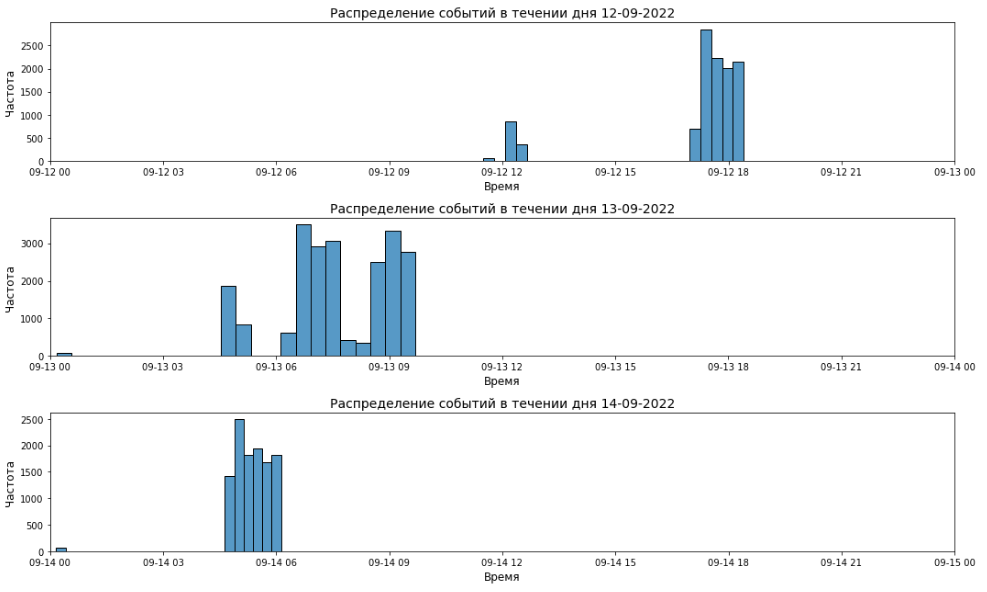

Гистограммы, построены на одинаковых осях времени (0:00:00 текущего дня до 0:00:00 следующего дня). Для 13-го и 14-го числа первая активность фиксируется в начале суток, тогда как 12-го числа только ближе в полудню. Возможно, это связано с тем, что 12-09-2022 это был понедельник, а для первого рабочего дня характерна низкая активность в первой половине. Тем не менее, для всех трёх дней характерна непостоянная загруженность в течении дня с пиком в первой половине по времени системы.

Дата | 12-09-2022   
--- | ---   
Первая активность | 2022-09-12 11:30:11.106628  
Последняя активность | 2022-09-12 18:24:18.389464  
Интервал | 0 days 06:54:07.282836  

Дата | 13-09-2022   
--- | ---   
Первая активность | 2022-09-13 00:10:27.967745  
Последняя активность | 2022-09-13 09:41:15.078643 
Интервал | 0 days 09:30:47.110898  

Дата | 14-09-2022   
--- | ---   
Первая активность | 2022-09-14 00:09:39.234361  
Последняя активность | 2022-09-14 06:07:47.609898 
Интервал | 0 days 05:58:08.375537

Интервалы между первой и последней активности от 6 до 9.5 часов. 14-го числа все активности прекращены уже к 6 утра.

---
---

<font size = 4> <b/> Ответы на вопросы.</font>


***Вопрос 1. Между какими событиями наибольший шаг? Указать пару идентификаторов событий с наибольшим шагом, относительно всей базы.***

В задании нет однозначного указания, должны ли быть эти события внутри одной задачи или нет. Было рассмотрено два варианта:
- наибольший шаг между событиями (все события в хронологическом порядке) 

Наибольший шаг: 14:28:24.155718
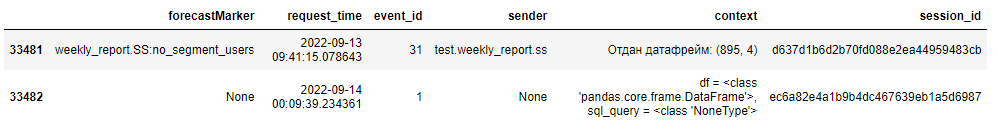
Как и следовало ожидать, исходя из графиков актичвостей представленных выше, наибольший шаг (бездействие системы) между завершением последней задачи 13-го и началом первой задачи 14-го сентября.


- наибольший шаг между событиями (события в рамках одной задачи)

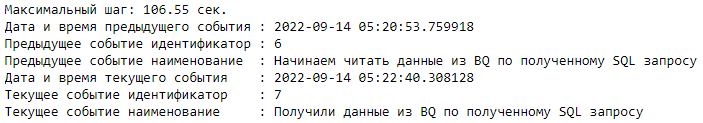


***Вопрос 2. Интервал времени до наступления какого события показывает наибольший разброс? Указать пару идентификатор - sender с наибольшим разбросом.***

По условию задачи, разброс - это разность между максимальной и минимальной величинами. Так как требуются указать пару идентификатор - sender, были рассмотрены интервалы по всем возможным парам.  
Пара идентификатор - sender с наибольшим разбросом:

event_id | sender
--- |---
7 | weekly_report.care

Событие с id 7 - это "Получили данные из BQ по полученному SQL запросу".  
То есть перед событием id 7 выполняется какой-то SQL запрос. Большой разброс для события , вероятно, связан с объемом данных по запросу.  
Анализ показывает, что выявленный случай не является исключением и большие (по сравнению с остальными) интервалы характерны для id 7.

Распределение по всем событиям.
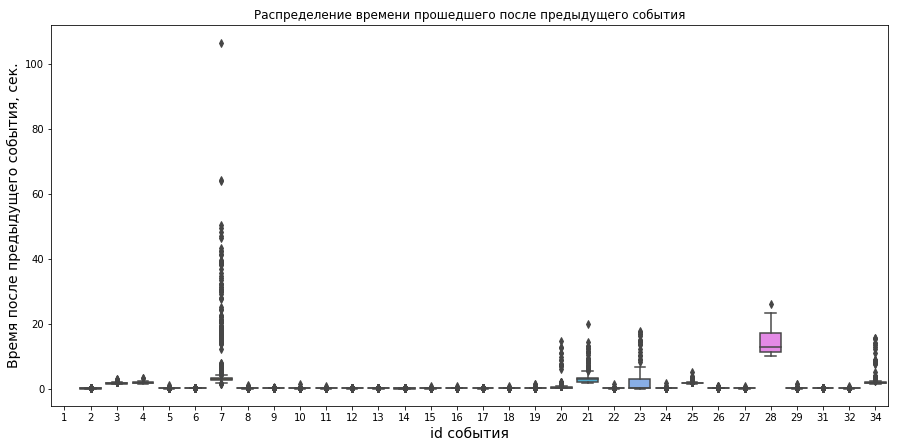


***Вопрос 3. Какая задача прогнозирования выполняется дольше всего (название задачи)?***

Для незавершенных задач принимаем за время окончание время последнего зафиксированного события задачи.  

Параметр | Значение  
--- | ---
Продолжительность выполнения, сек.| 112.48   
Начало |    2022-09-14 05:20:52.20 
Окончание | 2022-09-14 05:22:44.69  
Название задачи | weekly_report.care:count_of_jivo_SA 


***Вопрос 4. Какое количество задач прогнозирования может выполняться одновременно? Указать максимальное число параллельных задач.***

Будем полагать, что задачи по типу рекурсии являются независимыми в точки зрения учета параллельности выполнения.

Максимальное число одновременно выполняемых задач: 6


***Вопрос 5. Перечислить forecastMarker которые не завершились успешно.***

Задача прогнозирования считается завершенной успешно, если наступило событие с идентификатором 31. Задачи для которых такое событие не наступило:

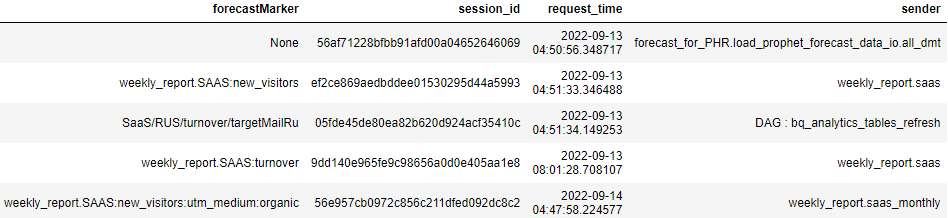

Список forecastMarker таких задач: 'None', 'weekly_report.SAAS:new_visitors', 'SaaS/RUS/turnover/targetMailRu', 'weekly_report.SAAS:turnover',  'weekly_report.SAAS:new_visitors:utm_medium:organic'